In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn import metrics

# Regresión Logística

## Fundamento teórico

El modelo de regresión asume que existe una relación lineal entre el logaritmo de los momios (logit) y los valores de la variable objetivo.

En el caso de clasificación binaria (clase positiva y negativa) podemos caracterizar totalmente el problema con la probabilidad de la clase positiva.

$$ \text{ln}\Big(\frac{p}{1-p}\Big) = \beta_0 + \sum_{j}{\beta_jX_j} = \textbf{X}\beta $$

De esta forma podemos estimar la probabilidad de que la variable independiente pertenezca a una clase dado el valor de las covariables aplicando la función logística al logit.

$$ p = \frac{1}{1 + e^{-\textbf{X}\beta}} $$

Para mas de dos clases se estiman de forma independiente las probabilidades uno contra el resto de cada clase. En general para $N$ clases se requieren $N-1$ modelos.

### Entrenamiento

Para entrenar un modelo de regresión logística se emplea máxima verosimilitud. Se asigna el valor de 0 a la clase negativa y 1 a la positiva y se escribe el estimador de verosimilitud en términos de las variables del modelo. Simplificando, el estimador queda definido de la siguiente forma:

$$ \hat{\ell}(\beta) = \frac{1}{n} \sum_{i=1}^{N}\big({y_i \beta^T x_i - \text{ln}(1 + e^{\beta^Tx_i})}\big) $$

### Regularización y selección de variables

Dado que se trata de un modelo lineal generalizado, este puede ser regularizado penalizando la magnitud de sus coeficientes de acuerdo a una métrica Lp. Para esto, el modelo se entrena maximizando una versión modificada del estimador de verosimilitud.

Penalizar el valor absoluto de los coeficientes resulta en un modelo Lasso que busca volver nulos los coeficientes de variables sin importancia para el problema predictivo. Es decir, puede utilizarse para realizar selección de variables.

$$ \hat{\beta} = arg\, max_{\beta} \{ \ell(\beta) - \lambda \sum_{j}{| \beta_j |} \} $$


## Datos

Se utilizarán los resultados de un análisis químico de vinos producidos en la misma región de Italia en tres cultivos distintos. Se tienen 13 medidas diferentes tomadas de varios constituyentes encontrados en los tres tipos de vino.

- alcohol: Contenido de alcohol
- malic_acid: Contenido de ácido málico (agrega acidez y aroma a manzana)
- ash: Contenido de ceniza (agrega frescura)
- alcalinity_of_ash: Alcalinidad de la ceniza
- magnesium: Contenido de magnesio
- total_phenols: Contenido total de fenoles (un alto contenido produce un sabor amargo)
- flavanoids: Flavonoides (produce un fuerte aroma y amargura)
- nonflavanoid_phenols: Fenoles no flavonoides (gas aromático ligeramente ácido)
- Proanthocyanins: Proantocianidinas (da un aroma amargo)
- color_intensity: Intensidad de color (depende del estilo del vino)
- Hue: Matiz (depende de la variedad y edad del vino)
- od280/od315_of_diluted_wines:
- Proline: Prolina (principal aminoácido del vino rojo, parte importante de su sabor en general)

Se tomara como clase de la variable objetivo al tipo de vino.

### Cargar datos

Se cargan los datos utilizando la utilidad de `scikit-learn` y se preparan como `DataFrame`.

In [2]:
data = load_wine()
df = pd.DataFrame(data=data['data'], columns=data['feature_names'])
vars_cols = list(df)
df['target'] = data['target']
df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258,0.938202
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474,0.775035
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000,0.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000,0.000000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000,1.000000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000,2.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000,2.000000


### Gráficas por pares

Se crea una gráfica de dispersión por cada par de variables y se indica su clase para facilitar encontrar patrones en los datos.

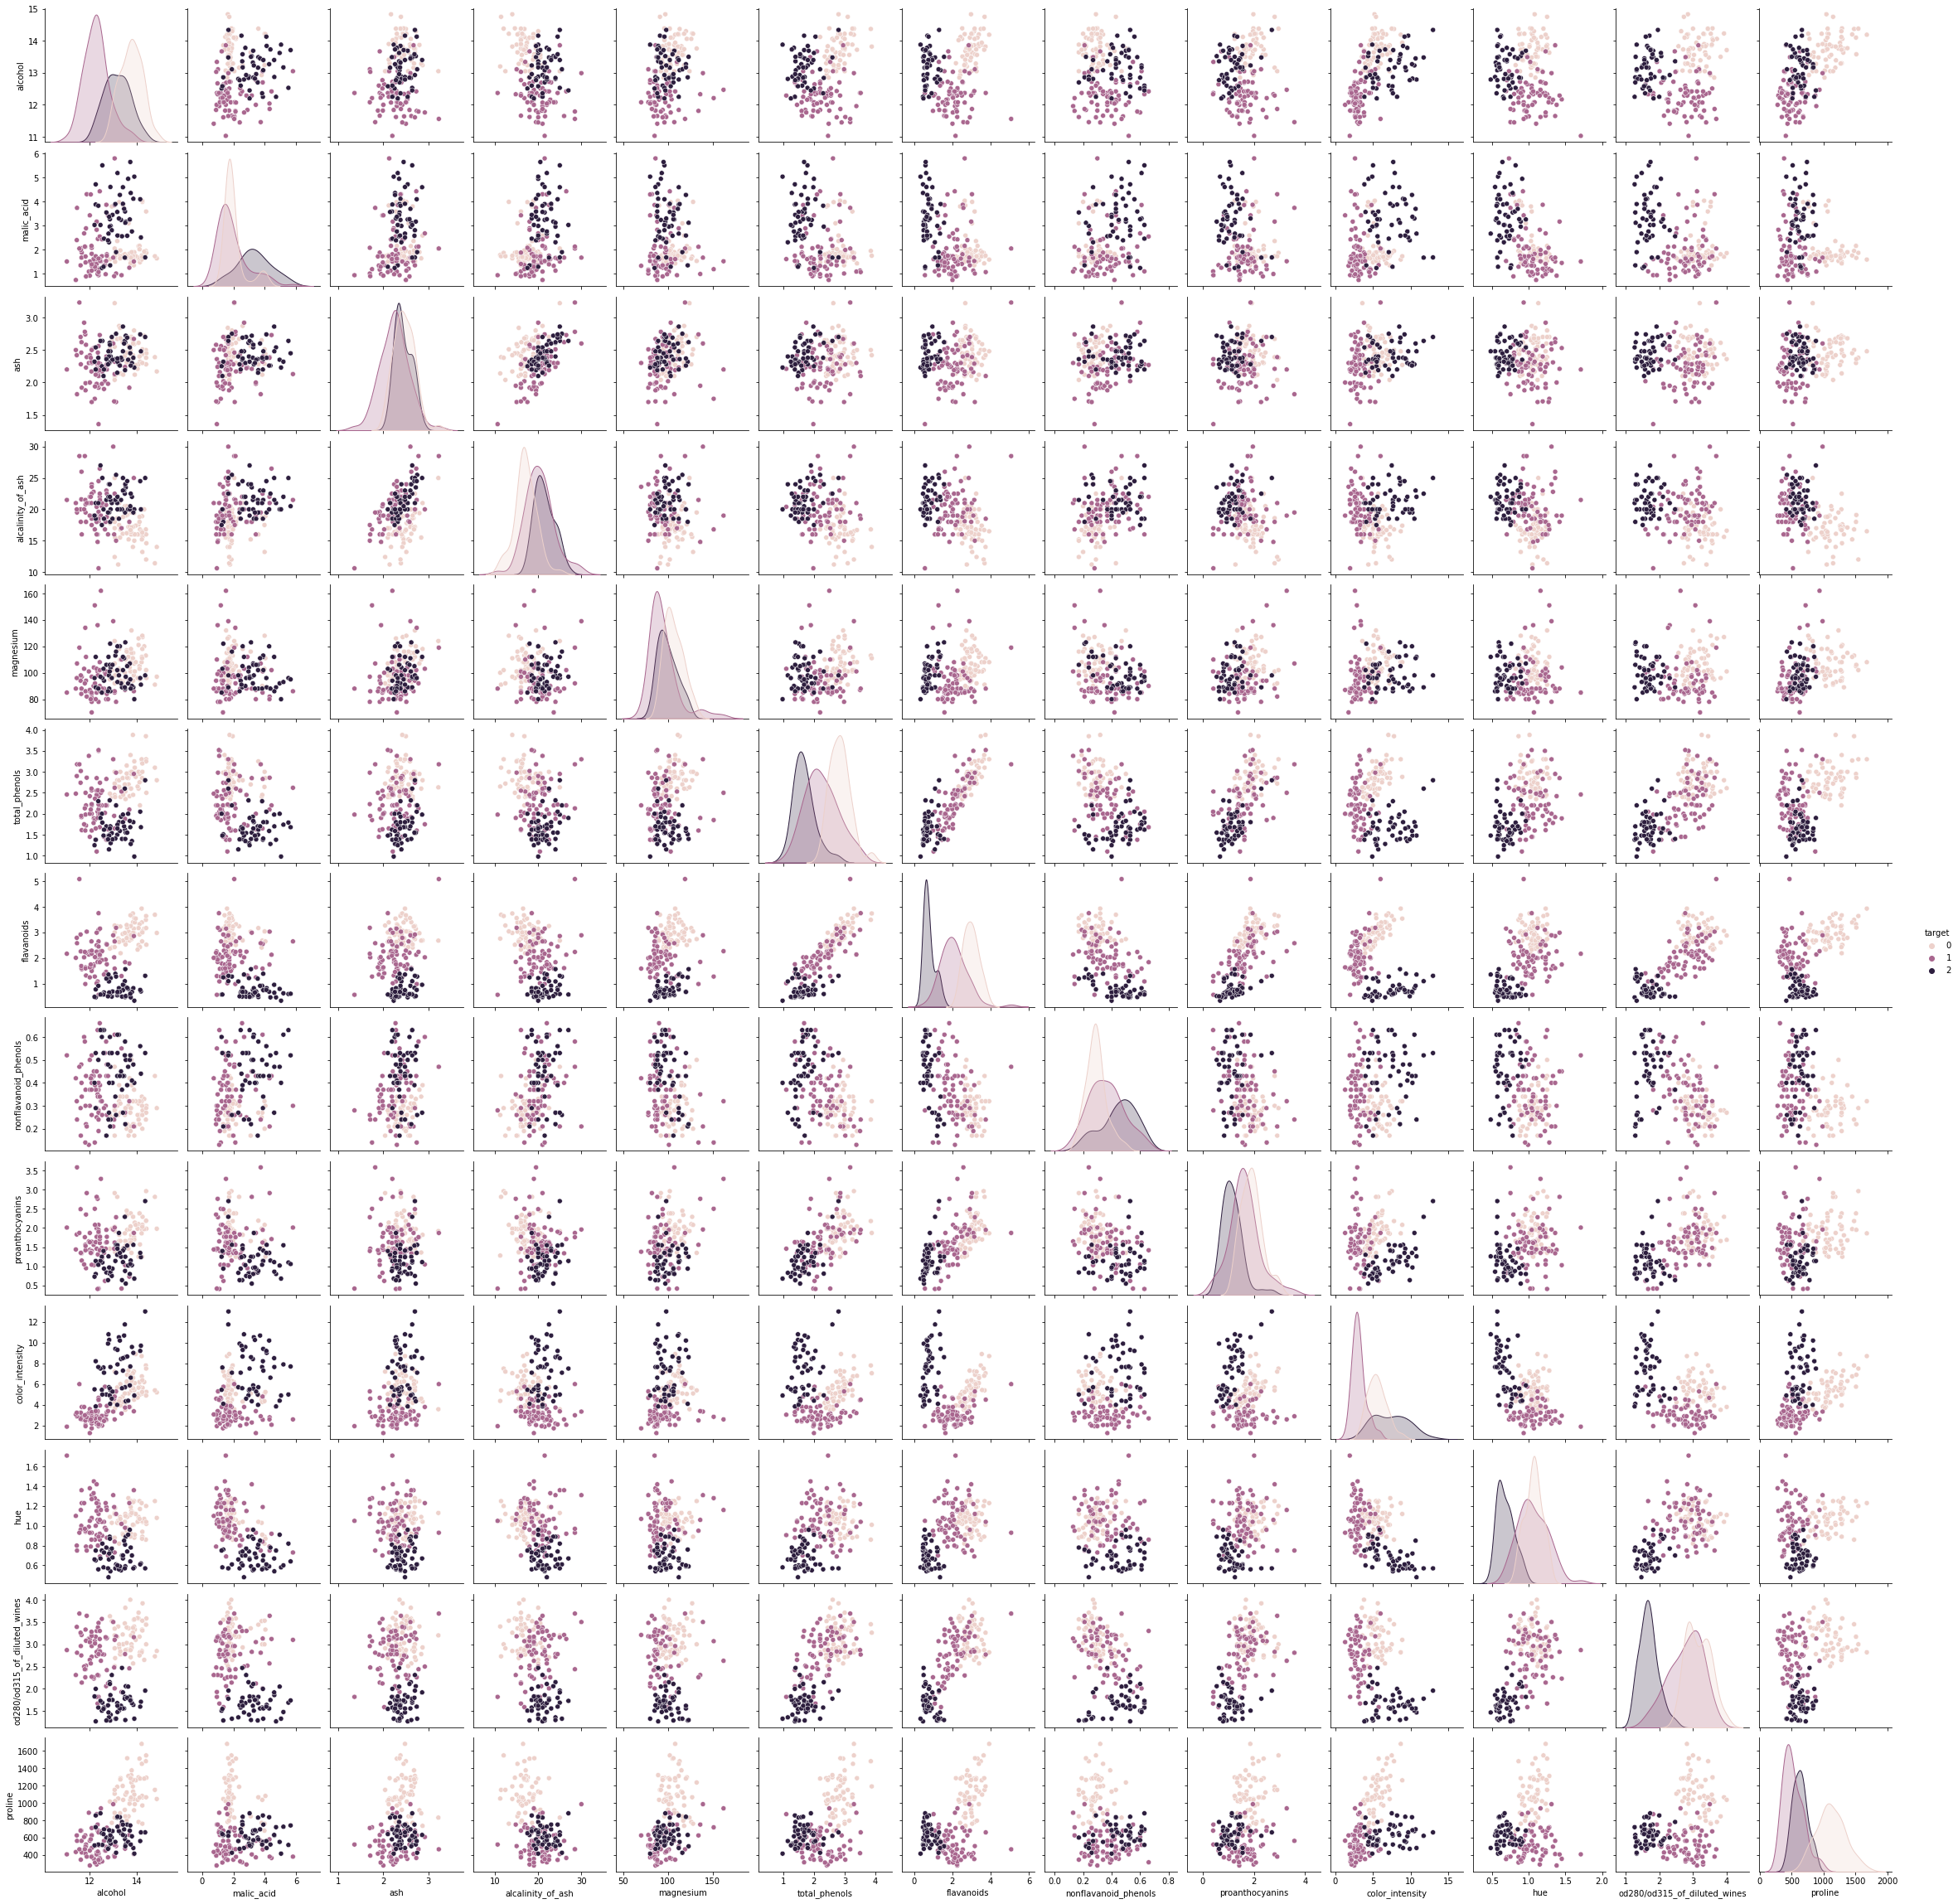

In [17]:
sns.pairplot(df, hue='target')
plt.show()

## Modelo

### Entrenamiento

Se dividen los datos de entrenamiento y evaluación. Se emplean los primeros para ajustar el modelo de regresión logística Lasso.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df[vars_cols], df.target,
                                                    test_size=0.33, random_state=0)

model = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

### Evaluación

Se analizan las predicciones del modelo en el conjuntode datos de evaluación

In [21]:
y_pred = model.predict(X_test)
conf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_report = metrics.classification_report(y_test, y_pred)

Gráfica de matriz de confusión

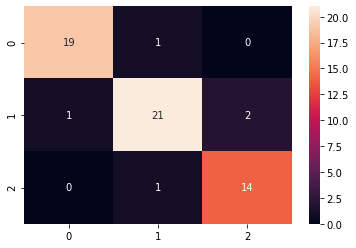

In [25]:
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.show()

In [24]:
print(class_report)

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.91      0.88      0.89        24
           2       0.88      0.93      0.90        15

    accuracy                           0.92        59
   macro avg       0.91      0.92      0.92        59
weighted avg       0.92      0.92      0.92        59



Se analizan los coeficientes del modelo para entender la relación entre covariables y variable objetivo

In [20]:
model_coeffs = pd.DataFrame(columns=data['target_names'], index=vars_cols, data=model.coef_.T)
model_coeffs

,class_0,class_1,class_2
alcohol,0.000000,0.045584,0.000000
malic_acid,0.000000,0.000000,0.000000
ash,0.000000,0.000000,0.000000
alcalinity_of_ash,-0.388433,0.118277,0.000000
magnesium,-0.044912,0.042204,-0.002484
total_phenols,0.000000,0.000000,0.000000
flavanoids,0.000000,0.000000,-0.922011
nonflavanoid_phenols,0.000000,0.000000,0.000000
proanthocyanins,0.000000,0.000000,0.000000
color_intensity,0.000000,-0.919967,0.743987


## Interpretación



El modelo entrenado muestra una precisión del 92% con una buena sensibilidad en las 3 clases (cercana al 90 en todas). Observando la matriz de confusión notamos que son pocos los casos que el modelo erra en clasificar la clase de vino. En general podemos decir que tenemos un buen modelo predictivo para este problema.

De los coeficientes del modelo podemos determinar qué variables tienen qué efecto en la estimación de la clase. A continuación se mencionan todas las relaciones causales encontradas.

Con respecto a las demás clases, la clase 0 está asociada a:
- Menor alcalinidad de la ceniza
- Menor contenido de magnesio
- Mayor contenido de prolina

Con respecto a las demás clases, la clase 1 está asociada a:
- Mayor contenido de alcohol
- Mayor alcalinidad de la ceniza
- Menor contenido de magnesio
- Menor intensidad de color
- Menor contenido de prolina

Con respecto a las demás clases, la clase 2 está asociada a:
- Menor contenido de magnesio
- Menor contenido de flavanoides
- Mayor intensidad de color
- Menor contenido de prolina

El modelo encontró que el resto de las variables no tienen importancia para predecir la clase de vino

## Referencias

- Bai, X., Wang, L., & Li, H. (2019). Identification of red wine categories based on physicochemical properties.
- Hastie, T., Tibshirani, R., & Friedman, J. (2009). The Elements of Statistical Learning. Springer New York. https://doi.org/10.1007/978-0-387-84858-7
- Lichman, M. (2013). UCI Machine Learning Repository [https://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.
